First, import the required packages.

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid",font_scale=1)
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
#from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
from IPython.display import display, HTML
from sklearn.linear_model import LogisticRegressionCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
from itertools import product


In [43]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

To begin with, we load the dataset. It is a pickle file, which we are loading as a dataframe. 

In [44]:
my_data=pd.read_pickle('my_dataset.pkl')
type(my_data)

dict

It will be comfortable to convert the dictionary to a pandas dataframe for easy data exploration. Using a pandas dataframe is  a better idea, since it allows us to slice and dice the data. Moreover, we assign employees, which were keys in the dictionary as a column in the dataframe. 

In [45]:
df = pd.DataFrame.from_records(list(my_data.values()))
df.shape

(146, 21)

This dataset has only 146 rows, which is significantly small

In [46]:
employees = pd.Series(list(my_data.keys()))
df['employees']= employees

In [47]:
df.index = range(1,len(df)+1)
#df.head(5)

In [48]:
#Replace NaN by 0 to take care of missing values.
df=df.fillna(0)
df=df.replace('NaN',0)
df_new=df
#df_new.columns

Since the missing values, NaN are actually text, it was important to use **replace()** function, so as to replace them by 0. 

## Outlier Detection
  In order to identify outliers, we identify employees where the sum of payment opions or stock options does not match
  total payments or total stock value. We found two employees, Sanjay Bhatnagar and Robert Belfer where payments do no match exactly. They can be treated as outliers. Comparing with the actual data in .pdf file, we observe that for above two employees,
    there is misalignment in the data. Next, we check the index Total, it certainly is an outlier and will be dropped.

In [49]:
df_new['total_payment'] = df_new['bonus']+df_new['deferral_payments']+df_new['deferred_income']+df_new['director_fees']\
                           +df_new['expenses']+df_new['loan_advances']+df_new['long_term_incentive']+df_new['other']+df_new['salary']


payment_unequal = df_new[df_new['total_payment']!=df_new['total_payments']]
payment_unequal

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,employees,total_payment
25,0,-102500,0,3285,0,3285,0,0,0,0,0,0,0,0,0,44093,0,0,0,102500,-44093,BELFER ROBERT,-99215
118,0,0,0,137864,sanjay.bhatnagar@enron.com,2604490,0,29,0,1,0,0,137864,0,-2604490,15456290,0,463,523,15456290,0,BHATNAGAR SANJAY,275728


We update the values for above two entities according to the pdf file.

In [50]:
df_new.at[25,'deferred_income']=-102500
df_new.at[25,'deferral_payments']=0
df_new.at[25,'expenses']=3285
df_new.at[25,'director_fees']=102500
df_new.at[25,'total_payments']=3285
df_new.at[25,'exercised_stock_options']=0
df_new.at[25,'restricted_stock']=44093
df_new.at[25,'restricted_stock_deferred']=-44093
df_new.at[25,'total_stock_value']=0

df_new.at[118,'total_payments']=137864
df_new.at[118,'expenses']=137864
df_new.at[118,'other']=0
df_new.at[118,'director_fees']=0
df_new.at[118,'exercised_stock_options']=15456290
df_new.at[118,'restricted_stock']=2604490
df_new.at[118,'restricted_stock_deferred']=-2604490
df_new.at[118,'total_stock_value']=15456290

After modifying the data for these two employees, Sanjay Bhatnagar and Robert Belfer, we recompute the value for the column total_payment, and check the values for above employees. We see that the values make sense now. Therefore, we don't need to drop these two rows. It is useful for our analysis, in the sense that we have a small dataset.

On the other hand, the employee names THE TRAVEL AGENCY IN THE PARK and TOTAL seem incorrect, and doesn't seem to represent Enron employees. Hence, they can be deleted.   

In [51]:
df_new=df_new[~df_new['employees'] .isin (['TOTAL','THE TRAVEL AGENCY IN THE PARK'])]

In [52]:
df_new.index=range(1,len(df_new)+1)

Are there any entries which are identically zero for all columns? We can safely delete those rows. 

In [53]:
#is there any row with zeroes in entire row
data_2 = df_new.drop(['employees','email_address'],axis=1)
data_2.columns
#df_new.iloc[89,]

Index([u'bonus', u'deferral_payments', u'deferred_income', u'director_fees',
       u'exercised_stock_options', u'expenses', u'from_messages',
       u'from_poi_to_this_person', u'from_this_person_to_poi',
       u'loan_advances', u'long_term_incentive', u'other', u'poi',
       u'restricted_stock', u'restricted_stock_deferred', u'salary',
       u'shared_receipt_with_poi', u'to_messages', u'total_payments',
       u'total_stock_value', u'total_payment'],
      dtype='object')

In [54]:
data_2['rowsum']=data_2.sum(axis=1)
idx=data_2[data_2['rowsum']==0].index
idx

Int64Index([24, 91], dtype='int64')

In [55]:
df_new.iloc[[23,90],:]

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,employees,total_payment
24,0,0,-98784,98784,0,0,0,0,0,0,0,0,0,0,32460,-32460,0,0,0,0,0,CHAN RONNIE,0
91,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,LOCKHART EUGENE E,0


We found that indices 24 and 91 have majority of entries as zero. In particular, index 91 has all entries 0 identically. Therefore we will delete those two indices from df_new. We saw that the employees are Chan Ronnie and Lockhart Eugene.

In [56]:
df_new.drop([24,91],inplace=True);
#df_new[df_new['employees'] .isin (['CHAN RONNIE','LOCKHART EUGENE E'])]

In [57]:
df_new.index=range(1,len(df_new)+1)

So, we have deleted four entries in total, resulting in dataset of size 142.

## Data Exploration Using Visuals
There are several numeric varibales, 21 of them.Before we decide the features which can decide whether an entity is POI or not, it is essential to perform Exploratory Data Analysis (EDA) on it.

## Payment Related Variables


To begin with, we look at some variables related to Payments Information. These include;
* Salary,
* Bonus,
* Long Term Incentive,
* Deferred Income,
* Deferral Payments,
* Loan Advances,
* Expenses,
* Director Fees, and 
* Total Payments.

### Distribution of Salary
Salary of the entity is numeric in nature. It will be suitable to compare the distribution for different levels of the response variable, POI. Boxplot seems a suitable choice for this purpose. Unfortunately Boxplot does not depict modality in the ditribution, if there are multiple points of maximum in the distribution of the numeric variable. In this case, violin plot seems to be suitable choice.   

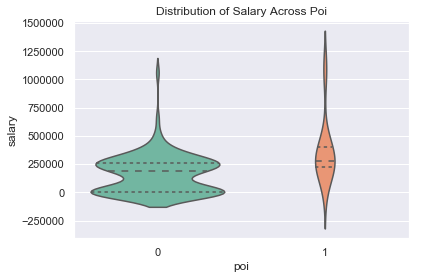

In [58]:
ax_violin = sns.violinplot(x="poi", y="salary",data=df_new, palette="Set2",scale="count", inner="quartile")
ax_violin.set_title("Distribution of Salary Across Poi")
plt.show()

Since I am learning the behavior of violin plot, it is essential to check the behavior of data, as depicted by the violin plot. We see that huge number of non-POI's had very low salary, as expected and represented by the width of the violin plot. Similarly, we have significant number of non-POI's with salary of around 250000. We should look at the salary distribution for non-POI's.  

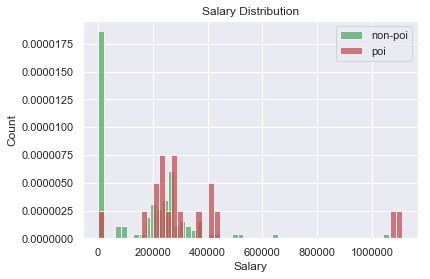

In [59]:
non_poi=df_new[df_new['poi']==0]
poi=df_new[df_new['poi']==1]
# the histogram of the data
plt.hist(non_poi['salary'], 50,density=True, facecolor='g', alpha=0.75,label='non-poi')
plt.hist(poi['salary'], 50, density=True,facecolor='r', alpha=0.75,label='poi')


plt.xlabel('Salary')
plt.ylabel('Count')
plt.title("Salary Distribution")
plt.legend(loc='upper right')
plt.show()

We observe significant variation in salary for both POI's as well as non-POI's. The median salary for POI's is significantly higher than their non-POI counterparts. Therefore, salary seems to be possible choice for predictor. Moreover, the mean is significantly higher than the median for POI's, hence heavily skewed distribution is expected. This skewness can be attributed to few significant outliers. Some senior level executives, who are also POI's earn insanely high salaries. On the other hand, the distribution for non-POI's is roughly normal, actually it is left skewed.

As a side blurb, we observe few outliers for both categories. It is expected that a POI can have large salary, but it will be interesting to identify the non-POI earning salary greater than 1 million. Lets find records coresponding to highest salary in both categories.  

Among the POI's, maximum salary is 1.112 milions, whereas the maximum salary for non-POI's is 1.06 millions. Let's identify the identities earning this amount. 

In [60]:
def top(data,n=1,column='salary'):
    return data.sort_values(by=column)[-n:]


In [61]:
df_new.groupby('poi').apply(top)[['employees','salary']]

,,employees,salary
poi,,,
0,125,FREVERT MARK A,1060932
1,94,SKILLING JEFFREY K,1111258


### Distribution of Bonus
Similar to Salary, Bonus is also a numeric variable. Therefore, we use boxplot together with POI, a categorical variable on the x-axis. It is expected that POI's get higher bonus.

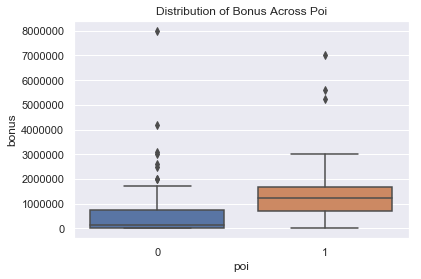

In [62]:
ax_bonus=sns.boxplot(x="poi",y="bonus",data=df_new)
ax_bonus.set_title("Distribution of Bonus Across Poi")
plt.show()

As expected, the Bonus for POI's is significantly higher than non-POI's, with some outliers. One non-POI is earning a bonus close to 8 millions. That seems interesting, and requires some investigation.

In [63]:
def top(data,n=2,column='bonus'):
    return data.sort_values(by=column)[-n:]

In [64]:
df_new.groupby('poi').apply(top)[['employees','bonus']]

employees    bonus
poi                                 
0   105     ALLEN PHILLIP K  4175000
    42      LAVORATO JOHN J  8000000
1   94   SKILLING JEFFREY K  5600000
    64        LAY KENNETH L  7000000

As per the New York Times article,https://www.nytimes.com/2002/06/18/business/officials-got-a-windfall-before-enron-s-collapse.html, many top level executives got huge bonuses/ gains just before collpase to prevent them from leaving the firm. That explains the above numbers.

### Long Term Incentive Pay
As per the above NYT article, top level executives were also paid huge Long Term Incentives. Were they paid only to POI's? Let's look at the distribution of Long Term Incentives to answer this question.  

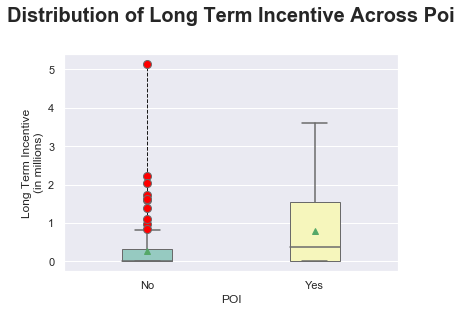

In [65]:
boxprops = dict(linestyle='-', linewidth=1)
flierprops = dict(marker='o', markersize=8,markerfacecolor='red',
                  linestyle='--')
ax_incentive=sns.boxplot(x="poi",y=df_new["long_term_incentive"]/float(1000000),orient="v",data=df_new,showmeans=True,\
                         palette="Set3",boxprops=boxprops,flierprops=flierprops,width=0.3)
#ticks=ax_incentive.set_xticks([0,1])
labels=ax_incentive.set_xticklabels(['No','Yes'])
ax_incentive.set_title("Distribution of Long Term Incentive Across Poi",y=1.12,fontsize=20,fontweight='bold')
ax_incentive.set_ylabel('Long Term Incentive\n(in millions)')
ax_incentive.set_xlabel('POI')
plt.show()

The box being asymmetrical depicts right skewness in both distributions, as expected. Moreover, the median incentive is higher for POI's. It will be interesting to identify the non-POI getting the highest long term incentive. 


In [66]:
df_new['poi'].dtypes

dtype('int64')

In [67]:
non_poi = df_new[df_new['poi']==0]
non_poi[non_poi['long_term_incentive']== max(non_poi['long_term_incentive'])][['employees','long_term_incentive']]


,employees,long_term_incentive
136,MARTIN AMANDA K,5145434


### Deferred Income

Deferred Income defines the income/revenue received for goods or services that are yet to be delivered. We intend to check whether POI's get higher Deferred Income. 

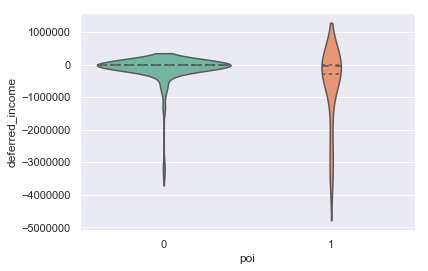

In [68]:
ax_deferred = sns.violinplot(x="poi", y="deferred_income",data=df_new, palette="Set2",scale="count", inner="quartile")
ax_violin.set_title("Distribution of Deferred Income Across POI")
plt.show()

### Expenses
Expenses include reimbursement of business expenses. It is highly expected that POI's make lots of trips, hence are heavily reimbursed.


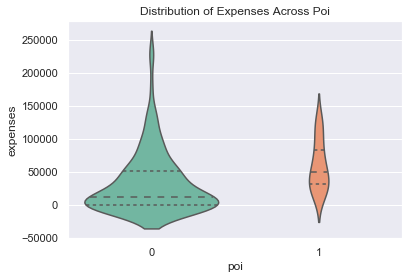

In [69]:
ax_expense = sns.violinplot(x="poi", y="expenses",data=df_new, palette="Set2",scale="count", inner="quartile")
ax_expense.set_title("Distribution of Expenses Across Poi")
plt.show()
#plt.show()

It is easy to notice that the POI's have significantly higher expenses as compared to their non-POI counterparts. At the same time, the distribution is right skewed for both classes. Since non-POI's have greater number of outliers, the right skewness is more significant as compared to their POI's counterparts. Some non-POI's have been reimbursed quite high expenses. Let's try to identify them.

In [70]:
non_poi_expenses = df_new[df_new['poi']==0]
non_poi_expenses[non_poi_expenses['expenses']== max(non_poi_expenses['expenses'])][['employees','expenses']]

,employees,expenses
110,MCCLELLAN GEORGE,228763


Since POI's have higher expenses than non-POI's, it is feasible to use expenses as a predictor for the classification model. 

### Distribution of Director Fees
Director fees is the payment made to an employee for their services as a director. It is voluntary decision to accept it or not if a person is sole director, but in case of multiple directors it has to be a joint decision. https://www.brooksonone.co.uk/knowledge-centre/limited-company/company-tax/directors-fees/

Now the question to answer is, are non-POI's also rendering services as a director.   

In [71]:
df_new.groupby('poi')['director_fees'].max()

poi
0    125034
1         0
Name: director_fees, dtype: int64

It seems that the POI's do not render serve their services as director. 

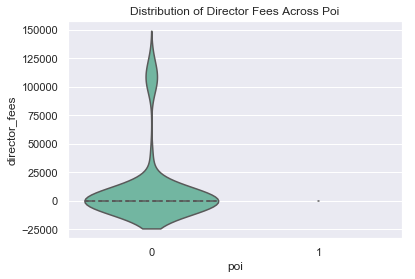

In [72]:
ax_director = sns.violinplot(x="poi", y="director_fees",data=df_new, palette="Set2",scale="count", inner="quartile")
ax_director.set_title("Distribution of Director Fees Across Poi")
plt.show()
#type(ax_director)

The distribution for Director fees is right skewed. Moreover, since all POI's have 0 director fees, we can possibly use this feature as a possible predictor to discriminate between the two classes.

### Distributon of Total Payments
As described, total payments describes the sum total of all payments/advances made to POI's as well as non-POI's.  

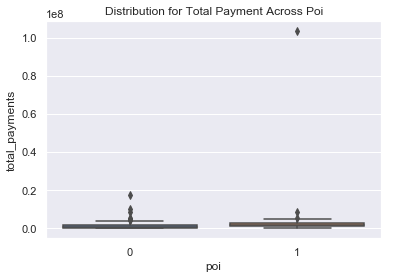

In [73]:
ax_total_payment=sns.boxplot(x="poi",y="total_payments",data=df_new)
ax_total_payment.set_title("Distribution for Total Payment Across Poi")
plt.show()

We don't see much variation here for POI's as well as non-POI's. There is only one remarkable point, which is certainly an outlier, for POI's.

In [74]:
poi_total=df_new[df_new['poi']==1]
poi_total[poi_total['total_payments']== max(poi_total['total_payments'])][['employees','total_payments']]

,employees,total_payments
64,LAY KENNETH L,103559793


Not so surprisinlgy, highest amount of payments has been made to Kenneth Lay, the founder of Enron.

Therefore, after studying the effects of relation between payment variables and whether a person is a POI or not, we decide to include following payment related variables in our clasification model;

* Expenses,
* Director Fees,
* Long Term Incentive,
* Bonus, and 
* Salary.

## Stock Related Features



 


### Distribution of Exercised Stock Options
It is highly likely that POI's are granted lower options for stock price as compared to regular stock prices. Therefore, is it possible that POI's are earning significantly more than non-POI's.  

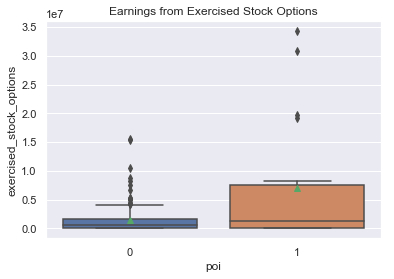

In [75]:
ax_exercised=sns.boxplot(x="poi",y="exercised_stock_options",data=df_new,showmeans=True)
ax_exercised.set_title("Earnings from Exercised Stock Options")
plt.show()

As expected, the POI's have earned significantly higher income by exercising stock options at the right time. But the disribution for POI's is highly right skewed. On the other hand, distribution for non-POI's is roughly normal. Actually the mean is slightly higher than median for non-POI cases. Let's check the stats.

In [76]:
df_new[df_new['poi']==0]['exercised_stock_options'].describe()

count    1.240000e+02
mean     1.501601e+06
std      2.645852e+06
min      0.000000e+00
25%      0.000000e+00
50%      6.046375e+05
75%      1.627556e+06
max      1.545629e+07
Name: exercised_stock_options, dtype: float64

As a side blurb, it will be interesting to check the outliers for POI's in terms of amount of exercised_stock_options. Most likely, it can be Kenneth Lay, the founder and CEO of Enron.

In [84]:
poi_exercised_stock = df_new[df_new['poi']==1]
poi_exercised_stock[poi_exercised_stock['exercised_stock_options']==max(poi_exercised_stock['exercised_stock_options'])][['employees',
                                       'exercised_stock_options']]

,employees,exercised_stock_options
64,LAY KENNETH L,34348384


As expected, highest revenue earned by exercising stock options belongs to Kenneth Lay. Let's look for top 3 executives who earned the highest  income exercising their stock options.

In [86]:
poi_exercised_stock.nlargest(3,'exercised_stock_options')[['employees','exercised_stock_options']]

,employees,exercised_stock_options
64,LAY KENNETH L,34348384
122,HIRKO JOSEPH,30766064
88,RICE KENNETH D,19794175


It is interesing to see that Joe Hirko and Kenneth Rice served as Co-CEO for Enron Broadband services until Joe Hirko left Enron in mid 2000.  

### Distribution of Restricted Stock
Restricted Stock is an award of company stock to employees but it can't be transferred or sold until few conditions are met. Some of these conditions include meeting certain performance goals or continued service to the company. The question we need to answer is, do the POI's receive larger share of restricted stock. 

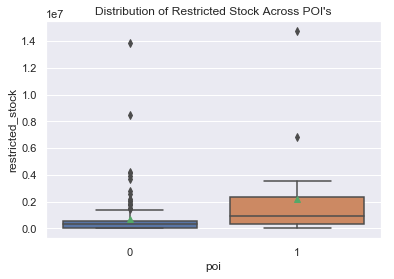

In [87]:
ax_restricted=sns.boxplot(x="poi",y="restricted_stock",data=df_new,showmeans=True)
ax_restricted.set_title("Distribution of Restricted Stock Across POI's")
plt.show()

Here are few observations from above boxplot; restricted stock is skewed in both classes, on an average restricted stock for POI's is much higher than non-POI's, and few outliers can be seen in both classes. It will be interesting to identify those outliers.

In [88]:
df_new.sort_values('restricted_stock',ascending=False).groupby('poi',sort=True).head(2).reset_index(drop=True)[['poi','restricted_stock','employees']]

,poi,restricted_stock,employees
0,1,14761694,LAY KENNETH L
1,0,13847074,WHITE JR THOMAS E
2,0,8453763,PAI LOU L
3,1,6843672,SKILLING JEFFREY K


Among the POI's, Kenneth L and Jeffrey Skilling have earned the most in restricted stock, whereas in the non-POI's,Thomas White  Jr and Pai Lou earned the most. Pai Lou was a former Enron Executive, whereas Thomas White Jr served as the Vice Chairman of Enron Energy Services.   

### Distribution of Restricted Stock Deferred
Restricted Stock Deferred reflects value of restricted stock which was deferred voluntarily under some predefined compensation arrangement. Let's check the distribution of deferred restricted stock for POI's as well as non-POI's.

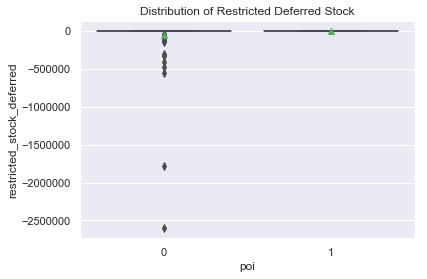

In [89]:
axes_restricted_deferred=sns.boxplot(x="poi",y="restricted_stock_deferred",data=df_new,showmeans=True)
axes_restricted_deferred.set_title("Distribution of Restricted Deferred Stock")
plt.show()

In [90]:
df_new[df_new['poi']==1]['restricted_stock_deferred'].describe()

count    18.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: restricted_stock_deferred, dtype: float64

For non-poi's, the restricted deferred stock  takes negative values, as seen in the boxplot. On the other hand, for poi's the value is identically zero. 

### Distribution of Total Stock Value
Next, we study distribution for total stock value across POI as well as non-POI's. It is expected that persons of influence will have higher stock value as compared to their non-POI counterparts. 

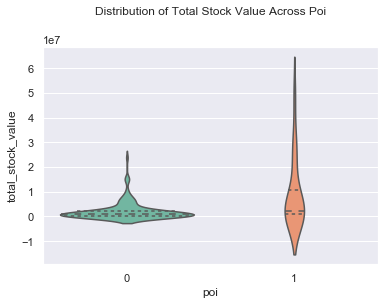

In [91]:
ax_total_stock = sns.violinplot(x="poi", y="total_stock_value",data=df_new, palette="Set2",scale="count", inner="quartile")
ax_total_stock.set_title("Distribution of Total Stock Value Across Poi",y=1.12)
plt.show()

As expected, POI's do have higher stock values at Enron. It will be worthwhile identifying the outliers in both groups, who caused heavy right skewness. 

In [92]:
df_new.sort_values('total_stock_value',ascending=False).groupby('poi',sort=True).head(3).reset_index(drop=True)[['employees','poi','total_stock_value']]

,employees,poi,total_stock_value
0,LAY KENNETH L,1,49110078
1,HIRKO JOSEPH,1,30766064
2,SKILLING JEFFREY K,1,26093672
3,PAI LOU L,0,23817930
4,BHATNAGAR SANJAY,0,15456290
5,WHITE JR THOMAS E,0,15144123


## Interaction with Other Users
Earlier we explored the effects of payments as well as stock variables on whether an entity is POI or not. Next, we use the features related to e-mail correspondence such as number of email messages, number of messages from POI, number of messages to POI, etc. 

### Distribution of Number of Messages Sent
Is it true that poi's send significantly larger number of messages? We use boxplot to observe the distribution of number of email messages w.r.t. POI's.

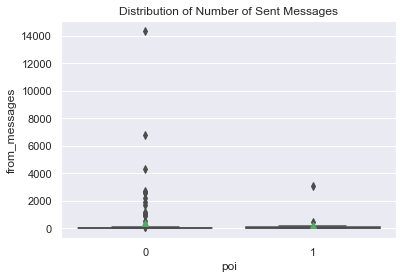

In [93]:
axes_from_messages=sns.boxplot(x='poi',y='from_messages',data=df_new,showmeans=True)
axes_from_messages.set_title('Distribution of Number of Sent Messages')
plt.show()

Using the boxplot above, we do not observe much discrimination in two classes. Significant number of outliers are observed in both classes. Next, we explore the distribution of the variables, to_messages.

### Distribution of Number of Messages Received
Are the POI's receiving more messages? It is possible that senior executives, and other people who have influence receive large number of emails. 

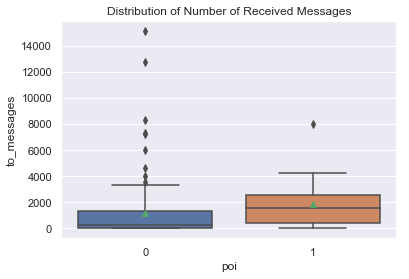

In [94]:
axes_to_messages=sns.boxplot(x='poi',y='to_messages',data=df_new,showmeans=True)
axes_to_messages.set_title('Distribution of Number of Received Messages')
plt.show()

So, answer is yes! Except few outliers, the POI's receive significantly larger number of emails as compared to their non-POI counterparts. Moreover, right skewness is observed for non-POI's, but for POI's we have a normal distribution. As a side blurb, we identify the outliers in case of non-POI's.

In [95]:
df_new[df_new['poi']==0].nlargest(3,'to_messages')[['employees','to_messages']]

,employees,to_messages
50,SHAPIRO RICHARD S,15149
100,KEAN STEVEN J,12754
23,KITCHEN LOUISE,8305


On a side note, is it true that POI's receive much more emails than they send. Let's look at the scatter plot, showing the discrimination between classes. 

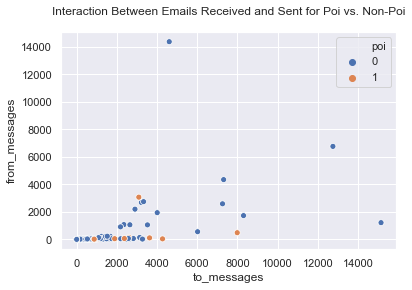

In [96]:
axes_email_sent_received = sns.scatterplot(x='to_messages',y='from_messages',hue='poi',data=df_new)
#(axes_email_sent_received.axes.flatten())[0].set_title('Interaction Between Emails Received and Sent for Poi vs. Non-Poi')
axes_email_sent_received.set_title('Interaction Between Emails Received and Sent for Poi vs. Non-Poi',y=1.05)
plt.show()

For POI's, we observe some sort of pattern. As expected, POI's do receive much more messages than they respond to. But the non-POI's have their numbers all over the graph.
In the Feature Engineering section, we define a new variable, ratio of number of messages received to number of messages sent. Question is, can this new variable be a decisive factor in discriminating two classes. Once the new variable is calculated, we use box plot to study its distribution for both classes.

### Distribution of Number of Messages from POI
It is highly likely that if an entity is a POI, then he/she will receive more messages from POI as compared to their non-POI counterparts. Similar to above approaches, we look at the boxplot.

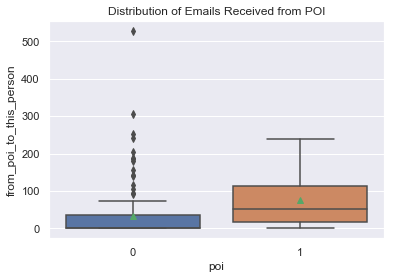

In [97]:
axes_poi_to_this_person = sns.boxplot(x="poi",y="from_poi_to_this_person",data=df_new,showmeans=True)
axes_poi_to_this_person.set_title("Distribution of Emails Received from POI")
plt.show()

As expected, the POI's receive more messages from other POI's as compared to non-POI's. But we see significant number of outliers in case of non-POI's. Interestingly, there are few non-POI's who seem to be popular among POI's. Let us identify few of those entities.  

In [98]:
df_new[df_new['poi']==0].nlargest(5,'from_poi_to_this_person')[['employees','from_poi_to_this_person']]

,employees,from_poi_to_this_person
42,LAVORATO JOHN J,528
123,DIETRICH JANET R,305
23,KITCHEN LOUISE,251
125,FREVERT MARK A,242
79,REDMOND BRIAN L,204


John Lavorato as the news says, was a former high ranking North American Enron Executive. It seems, though he was not a POI, he was in constant touch or contact with other POI's at Enron. Another non-POI, Janet Dietrich worked as the Chief Operating Officer for Enron Energy Services in the period 2000-2002.  

### Distribution of Number of Messages to POI
Is it necessary that a POI sends most of his messages to other POI? Or can non-POI's also send significant number of messages to other POI's.




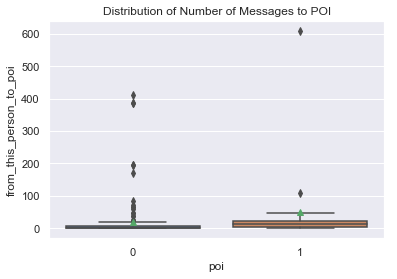

In [99]:
axes_messages_to_poi=sns.boxplot(x='poi',y='from_this_person_to_poi',data=df_new,showmeans=True)
axes_messages_to_poi.set_title('Distribution of Number of Messages to POI')
plt.show()

Except few outliers, we can't be confident that a POI sends significantly larger number of messages to POI as compared to non-POI's. It might not be suitable to use this variable as a possible predictor for the classification model.

### Distribution of Number of Messages Shared with POI
It is highly likely that a POI will share significantly larger number of messages with POI, as compared to non-POI's.

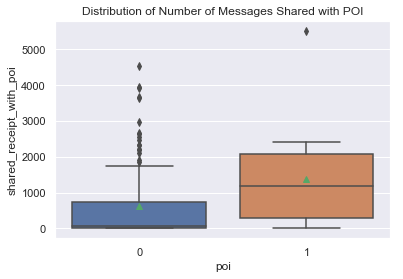

In [100]:
axes_shared_with_poi=sns.boxplot(x='poi',y='shared_receipt_with_poi',data=df_new,showmeans=True)
axes_shared_with_poi.set_title('Distribution of Number of Messages Shared with POI')
plt.show()

Our intuition make sense, the POI's on an average do share lots of emails with POI's. Moreover, the distribution is roughly normal for POI's. Except one outlier, the ditribution is almost symmetrical.
On the other hand, for non-POI's, significant number of outliers lead to right skewness of the distribution. It will be interesting to identify those outliers for case of POI's as well as non-POI's.

In [101]:
df_new[df_new['poi']==0].nlargest(2,'shared_receipt_with_poi').reset_index(drop=True)[['employees','shared_receipt_with_poi']]

,employees,shared_receipt_with_poi
0,SHAPIRO RICHARD S,4527
1,LAVORATO JOHN J,3962


We observed earlier that John Lavorato did receive lots of messages from POI's. Hence it is not surprising that he shared several emails with POI's. Another eminent personality, Richard Shapiro served as Enron's outreach to Democrats during the 2000 presidential race; (https://www.nytimes.com/2002/02/18/us/enron-pursued-plan-to-forge-close-ties-to-gore-campaign.html). That explains why Richard shared so many messages with other POI's.  Next, we identify the outlier for POI's.

In [102]:
df_new[df_new['poi']==1].nlargest(1,'shared_receipt_with_poi').reset_index(drop=True)[['employees','shared_receipt_with_poi']]

,employees,shared_receipt_with_poi
0,BELDEN TIMOTHY N,5521


Timothy Belden was the head of trading in Enron Energy Services. He was responsible for California's energy crisis and got a huge bonus of 5 million dollars for the profits he extracted for Enron from California's crisis.

### Feasible Predictors
Using above EDA results, following variable seem to be suitable for our classification model;
* Salary,
* Bonus,
* Long Term Incentive,
* Director Fees,
* Expenses,
* Exercised Stock Options,
* Restricted Stock,
* Total Stock Value,
* Number of Messages Received,
* Number of Messages Received from POI, and 
* Number of Messages Shared with POI.

Before we proceed with scaling and other pre-procesing steps required to build the model, we shoud observe the correlation coefficients  between possibly all non-text variables. This will help us to reduce effects of multicollinearity, if present.

### Correlation Matrix
For the present analysis, we plan to focus only on payment as well as stock variables. The text variables such as email address and employee names will be ignored.

In [103]:
#filter the dataset to include above possible predictors.
stock_payment_email_data=df_new.drop(['poi','employees','email_address'],axis=1)
#compute the correlation matrix
corr=stock_payment_email_data.corr()

In [104]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

In [105]:
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

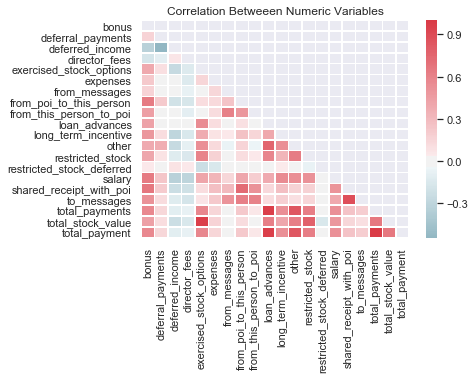

In [106]:
# Draw the heatmap with the mask and correct aspect ratio

axes_heat=sns.heatmap(corr, mask=mask, cmap=cmap, center=0,cbar=True,
             linewidths=.5,xticklabels=True,yticklabels=True, cbar_kws={"shrink": 1})
#sns.plt.suptitle('lalala')
axes_heat.set_title("Correlation Betweeen Numeric Variables")
plt.show()

From the correlation matrix, it is easy to notice that following variables are strongly correlated;
* Exercised Stock Options and total_stock_value,
* to_messages and shared receipt with poi,

This information is useful, in the sense that only one of those pairwise related variables needs to be considered while building the classification model. We can use both highly correlated variables, but it won't help since information is repeated.
 
 



## Regularized Logistic Regression
To begin the modeling process, we will go for the simple logistic regression model. To get best set of features, we will use L1- regularization, i.e. lasso regression. It is better in the sense that features are automatically selected using this method. Features that do not help much in discrimination are automatically dropped and helps to obtain a interpretable model. One of the main tasks in algorithms involving regularization is to select the proper vlaue of regularization parameter, $C$. Actually $C$ is the inverse of the regularization parameter, $\lambda$. Higher the lambda, more regularization and we get a simple model with larger number of coefficients being pushed towards zero. It gives a simple model, but likely to underfit, even on the trainings set, a phenomenon called bias. On the other hand,  a very low value of lambda keeps almost all the features, most likely giving a complex model. The complex model petty much learns the training data and gives flawless performance on the training set, but generalizes poorly on the test set, hence overfitting. It should be noted that the main task of modeling is to be able to make reliable predictions on unseen data.
Therefore, choosing a suitable value of parameter $C$, hence $\lambda$ is crucial and can be done by cross validation. 


Presently, we plan to use only numeric variables for classification purpose. Therefore, we can safely drop text variables, employee name, and email address. It will be useful to scale the numeric variables such that they lie in the range $[0,1]$.

In [107]:
numeric_data_logit = df_new.drop(['employees','email_address'],axis=1)
X=numeric_data_logit.drop(['poi'],axis=1).copy()
y=df_new['poi'].copy()

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2, random_state=42,shuffle=True,stratify=y)


In [108]:
#scale the features

scaler = MinMaxScaler()
scaler.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [109]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
#type(X_train_scaled)

Once the scaling and transformation is done, we approach the main problem, selecting $C$ through cross-validation. One of the most popular methods to cross validate is using $k$-fold cross validation. In this approach, for every iteration, the training set is divided into two sets, one part is called validation set (or fold) and rest is training set. The model is trained on the training set and its performance is tested on the validation set.

This process is repeated $k$ number of times, where $k$ is number of folds, default value is 5. This method can be used to choose optimal value of hyperparameters, in our case, parameter $C$. For our case, sickit learn gives default set of 10 values of $C$ ranging from low (i.e. high regularizaton) to high (i.e. low regularization). For each value of $C$, we train the model 5 times and test it on every fold i.e. validation set. Using a suitable metric (possibly $F1$ score for skewed data) we choose the best value of $C$. The mean value of $F1$ is taken over all 5 folds for each value of $C$ and we choose the $C$ corresponding to highest mean $F1$ score.   

In [110]:
type(y_train)

pandas.core.series.Series

In [111]:
clf= LogisticRegressionCV(Cs=10,fit_intercept=True,cv=5,dual=False,penalty='l1',scoring='f1',solver='liblinear',
                     class_weight='balanced',multi_class='ovr',random_state=42)
clf.fit(X_train_scaled,y_train)

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=42,
           refit=True, scoring='f1', solver='liblinear', tol=0.0001,
           verbose=0)

In [112]:
#find the best value of C so that mean f1 score is the best

clf.C_

array([2.7825594])

In [113]:
#set of C values used

clf.Cs_

array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])

In [114]:
#final set of coefficients for the features used

clf.coef_

array([[ 3.47366268, -8.76784005, -3.49333086, -0.92172098,  0.35922662,
         2.76001484,  0.        ,  3.32686321,  0.22970512,  0.        ,
         0.        ,  0.        ,  0.        ,  1.07390994,  1.79224754,
         0.        , -1.85563837,  0.        ,  4.91670508,  0.        ]])

In [115]:
#Identify the features which seem to be unimportant while doing lasso regression 
X.columns[clf.coef_[0]==0]

Index([u'from_messages', u'loan_advances', u'long_term_incentive', u'other',
       u'restricted_stock', u'shared_receipt_with_poi', u'total_payments',
       u'total_payment'],
      dtype='object')

An interesting observation; the features long_term_incentive and shared_receipt_with_poi have been eliminated during the regularization process. This does not mean that these features are not statistically significant while discriminating poi's from non-poi's. On the other hand, we saw in the EDA section that these features exhibit different behavior across both classes.  The lasso regression tells us that for that optimal value of parameter, $C$ these features are not contributing much to the classification process. It does not convey much information regarding stastical significance of the predictors.



Now that we have obtained the $F1$ score on the entire training set, the next step is to do the predictions on the test set. We plan to use area under the ROC curve(i.e. AUC) as the performance measure. To this end, we predict probabilities of the individual being a POI on the test set. Using those predicted probabilities, we can plot the ROC curve and compute the AUC. Higher the AUC, better is the model. 

In [116]:
pred_proba=clf.predict_proba(X_test_scaled)
pred_proba;

In [117]:
fpr, tpr, thresholds = metrics.roc_curve(y_test,pred_proba[:,1],1)
roc_auc=metrics.roc_auc_score(y_test,pred_proba[:,1])
roc_auc

0.6799999999999999

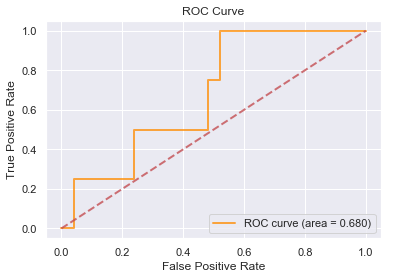

In [118]:
plt.plot(fpr, tpr, lw=2, alpha=0.75, color='darkorange',label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

#### Discussion About ROC
Every point in the ROC Curve is defined by the co-ordinates, False Positive Rate(FPR) and True Positive Rate(TPR). Each pair of FPR and TPR is computed for a given value of threshold probability. The function predict_proba gives probabilities predicted by the model. When the predicted probability is geater than threshold value, that example is labeled as 1 ('poi') by the model else 0 ('non-poi'). The quantities TPR and FPR can be computed as follows;

$$TPR=\frac{\text{Number of True Positives}}{\text{Total Number of Positive Examples(regardless of classification)}},$$
$$FPR=\frac{\text{Number of False Positives}}{\text{Total Number of Negative Examples(regardless of classification)}}$$

The above graph is jumpy due to small test data size. Another interesting property of ROC curve is to find the optimal value of threshold probability, which will give the best TPR as well as the lowest FPR possible. Once the optimal cutoff is computed, we will label the test data using the cut off probability and predicted probailities by our model.
A straightforward approach to find the optimal threshld is to treat both classes with equal weightage and find the threshold which maximises the difference between TPR and FPR. 

In [119]:
cutoff = thresholds[np.argmax(tpr - fpr)]
cutoff

0.2121637608566848

In [120]:
probs_logit=pred_proba[:,1]
probs_logit[probs_logit>=cutoff]=1
probs_logit[probs_logit<cutoff]=0
probs_logit

array([0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0.])

After we label the test data as per our model, our task is to asess the performance of our model against the true data. For skewed data (i.e unbalanced concentration of classes) it is beneficial to use precision or recall as the performance yardsticks. Recall is the ability of the classifier to capture as many positive examples as possible, whereas Precision makes sure that an example is labelled positive only when the model is highly confident of that example being positive.

In [121]:
recall_score(y_test,probs_logit)

1.0

In [122]:
precision_score(y_test,probs_logit)

0.23529411764705882

#### Discussion
Using the optimal cut-off obtained from the ROC crve, we obtain perfect Recall score but a low Precision. This is a typical classification scenario. As discussed earlier, Recall is the ability to capture as many positive examples as possible. In that process, the model sometimes identifies negative examples as positive so as not to leave any positive example behind. But this leads to lower true positive rate, i.e. Precision. This precision-recall tradeoff leads to an important question, which metric do we care more about? The answer depends on the business setting.

In our example, we are trying to identify persons of influence, who might be involved in the Enron financial crisis. Therefore, it makes sense for us to capture all the POI's for sure. If some non-POI's also get captured, it is a risk worth taking. But we don't want to miss the POI's for sure.

### 5-Fold Cross Validation Modified
In the above approach, we used the average $F1$ score across 5 folds of small size to choose optimal value for $C$. Therefore, we can't be very confident whether the model we got is optimal. This happened mostly becuse of our limited data size, just 142 records. To counter this problem, we plan to perform cross validation in a slightly different way in this section. To preserve consistence of class representation across folds, it is better to choose stratified approach. We use the datasets, X_train_scaled and X_test_scaled from above. Here is the strategy;

For each value of $C$;
 * Perform 5-fold validation on train set,
 * Predict probabilities on each fold,
 * Concatenate the predicted probbailities to get enough sample size,
 * Use the concatenated list of predicted probabilities together with the entire training set to obtain the AUC.

The goal is to find the parameter $C$ which gives the highest AUC.

In [123]:
y_train.index=range(0,len(y_train))
print(len(y_train));
print(X_train_scaled.shape);

113
(113, 20)


In [124]:
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
for c in ['1.00000000e-04', '7.74263683e-04', '5.99484250e-03', '4.64158883e-02','3.59381366e-01', '2.78255940e+00', '2.15443469e+01', '1.66810054e+02',
       '1.29154967e+03', '1.00000000e+04']:
    proba_list1=[]
    validation_list1=[]
    for train_index, test_index in skf.split(X_train_scaled, y_train):
        X_train, X_valid = X_train_scaled[train_index], X_train_scaled[test_index]
        y_train_new, y_valid = np.array(y_train)[train_index], np.array(y_train)[test_index]
        #print X_train.shape,y_train_new.shape
        clf_logit = LogisticRegression(penalty='l1',C=float(c),random_state=42).fit(X_train, y_train_new)
        probab=clf_logit.predict_proba(X_valid)
        #print X_train.shape,X_valid.shape
        proba_list1.append(list(probab[:,1]))
        validation_list1.append(list(y_valid))
    validation_probs=[i for s in proba_list1 for i in s]
    validation_label=[i for s in validation_list1 for i in s]
    #fpr, tpr, thresholds = metrics.roc_curve(np.array(validation_label),np.array(validation_probs),1)
    auc = metrics.roc_auc_score(np.array(validation_label),np.array(validation_probs))
    #print auc
    #print type(float(c))
    print "For C= %0.2f the AUC is given by %0.2f" %(float(c),auc)

    
    

For C= 0.00 the AUC is given by 0.50
For C= 0.00 the AUC is given by 0.50
For C= 0.01 the AUC is given by 0.50
For C= 0.05 the AUC is given by 0.53
For C= 0.36 the AUC is given by 0.55
For C= 2.78 the AUC is given by 0.78
For C= 21.54 the AUC is given by 0.74
For C= 166.81 the AUC is given by 0.64
For C= 1291.55 the AUC is given by 0.52
For C= 10000.00 the AUC is given by 0.53


From the above analysis, we deduce that C=2.78 gives the highest value of AUC. Therefore, it makes sense to train the entire training set now using this value.

In [125]:
clf_optimal = LogisticRegression(penalty='l1',C=float(2.78)).fit(X_train_scaled, y_train)

In [126]:
test_prediction=clf_optimal.predict(X_test_scaled)
print classification_report(y_test, test_prediction)

             precision    recall  f1-score   support

          0       0.88      0.92      0.90        25
          1       0.33      0.25      0.29         4

avg / total       0.81      0.83      0.82        29



It should be noted that here the default threshold has been used (i.e. 0.5) to perform the classification. Another question worth consideting is, whether this threshold is a good choice for the problem at hand.

In [127]:
pred_proba_opt=clf_optimal.predict_proba(X_test_scaled)
fpr, tpr, thresholds = metrics.roc_curve(y_test,pred_proba_opt[:,1],1)
roc_auc=metrics.roc_auc_score(y_test,pred_proba_opt[:,1])
roc_auc


0.6699999999999999

#### Discussion
This model where more data points have been used to find the optimal value of $C$ is not better, in terms of AUC, than the previous model using regular cross validation. We can still obtain perfect Recall but at cost of low Precision. This serves our purpose, so as to capture all poi's. But if we desire a better precision too, it is worthwhile looking for better models.
One possible approach is to make new features from exising ones, i.e. feature engineering.

## Feature Engineering
Next, we check whether additional information can be generated from existing features. It seems a suitable option to define new features.
Earlier, we saw that a poi on an average receives much more messages than he/she responds to. It will be useful to define a new feature; **ratio of from messages to received messages**. Next, our intuition is that out of all messages received, a poi is likely to receive higher number of messages from poi, as compared to their non-poi counterparts. It makes sense to define a new variable which meaures proportion of messages received from poi to  a given entity; let's call it **proportion_from_poi**. Another feature we can define is **total no. of messages**. Moreover, we can check proportion of received messages that were shared with a poi. This information is stored in the variable, **shared_with_poi_prop**.  
In addition to email related features, we also define new features related to payment data. It is highly likely that poi's got huge bonuses as a share of their salary. Using this intuition, we define **bonus_salary_ratio** as ratio of Bonus to salary for the employee.
Earlier, we saw that there are many entries with features as 0. While engineering these new features, it is possible that division by zero might occur. We will impute them by the median to avoid division by 0. 

In [128]:
median_from_messages = df_new['from_messages'].median()
median_to_messages = df_new['to_messages'].median()
median_salary = df_new['salary'].median()
df_new2=df_new.copy()
df_new2.replace({'from_messages': {0: median_from_messages},'to_messages':{0:median_to_messages},\
                'salary':{0:median_salary}},inplace=True)

In [129]:
df_new2['email_messages_ratio'] = np.round(df_new2['to_messages']/df_new2['from_messages'],2) 
df_new2['proportion_from_poi']= np.round(df_new2['from_poi_to_this_person']/df_new2['to_messages'],2)
df_new2['total_messages']= df_new2['to_messages']+df_new2['from_messages']
df_new2['bonus_salary_ratio'] = np.round(df_new2['bonus']/df_new2['salary'],2)
df_new2['shared_with_poi_prop']=np.round(df_new2['shared_receipt_with_poi']/df_new2['to_messages'],2)
df_new2['bonus_salary_sum'] = np.round(df_new2['bonus']+df_new2['salary'],2)


Now that we have constructed some new features, the original features are kinda redundant. Therefore, it makes sense to drop the original features, **to_messages**,**from_messages**,**shared_receipt_with_poi**,**bonus**, and **salary**.   

In [130]:
df_new2.drop(['to_messages','from_messages','shared_receipt_with_poi','bonus','salary'],axis=1,inplace=True)

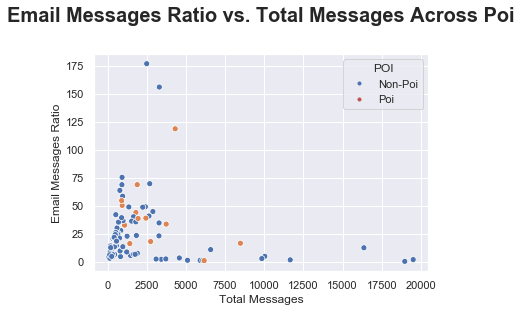

In [131]:

#it makes. sense to check whether the features, total messages and email messages ratio follow a pattern across poi's.
custom = [Line2D([], [], marker='.', color='b', linestyle='None'),
          Line2D([], [], marker='.', color='r', linestyle='None')]

ax_total_message_ratio=sns.scatterplot(x='total_messages',y='email_messages_ratio',hue='poi',data=df_new2)
ax_total_message_ratio.set_title("Email Messages Ratio vs. Total Messages Across Poi",y=1.12,fontsize=20,fontweight='bold')
ax_total_message_ratio.set_ylabel('Email Messages Ratio')
ax_total_message_ratio.set_xlabel('Total Messages')
#ax_total_message_ratio.legend(loc="upper right")
ax_total_message_ratio.legend(custom,['Non-Poi','Poi'],title="POI",loc="upper right")
plt.show()

### Correlation Matrix
Now that we have new features defined, it will be interesting to see the correlation among all variables. Once we identify highly correlated variables, we can use that information to drop redundant information.

In [132]:
numeric_data=df_new2.drop(['employees','email_address','poi'],axis=1)
numeric_data.shape

(142, 21)

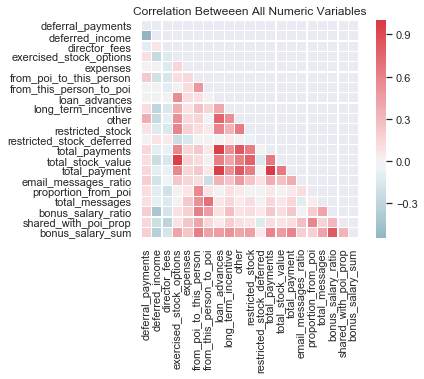

In [133]:
corr_numeric=numeric_data.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_numeric, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio

axes_heat=sns.heatmap(corr_numeric, mask=mask, cmap=cmap, center=0,cbar=True,
            square=True, linewidths=.15, xticklabels=True,yticklabels=True,cbar_kws={"shrink": 1})
#sns.plt.suptitle('lalala')
axes_heat.set_title("Correlation Betweeen All Numeric Variables")
plt.show()

From the above correlation matrix, we deduce that following variables are pairwise highly correlated;
* total payments and loan advance,
* exercised stock options and total stock value, and
* bonus salary ratio and total_bonus_salary.

The variables, exercised stock options and total stock value seem to be quite different. The correlation between them is not obvious, therefore it makes sense to perform Principal Component Analysis (PCA) on these two variables to find independent and uncorrelated components. Before performng PCA, we should make sure that these two variables are on similar scale, otherwise standardization is needed. 
Aside, it is always helpful practice to have features on similar scale, otherwise some features might dominate, possibly causing slow convergence.




In [134]:
df_new2[['exercised_stock_options','total_stock_value']].describe()

,exercised_stock_options,total_stock_value
count,1.420000e+02,1.420000e+02
mean,2.195521e+06,3.059926e+06
std,4.951310e+06,6.305474e+06
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,3.248138e+05
50%,6.224980e+05,9.860165e+05
75%,1.714221e+06,2.453312e+06
max,3.434838e+07,4.911008e+07


In [135]:
correlated_stock_features=df_new2[['exercised_stock_options','total_stock_value']].copy()


These two features are already on similar scale, hence rescaling is not needed. We can go ahead wth the PCA task. 

In [136]:
pca=PCA(n_components=1)
stock_features_proj=pca.fit_transform(correlated_stock_features)
stock_features_df=pd.DataFrame(stock_features_proj)
stock_features_df.index = range(len(stock_features_df))
stock_features_df.columns=range(stock_features_proj.shape[1])
stock_features_df.shape


(142, 1)

In [137]:
stock_features_df.rename(columns={0:'proj_stock_value_options'},
inplace=True)
stock_features_df.head(5)

,proj_stock_value_options
0,-3.301544e+06
1,8.723228e+06
2,4.510938e+06
3,-2.543579e+06
4,4.681763e+06


Similarly, we will perform pca on other correlated features. Let's check their stats first, whether we need to standardize them.

In [138]:
df_new2[['total_payments','loan_advances']].describe()

,total_payments,loan_advances
count,1.420000e+02,1.420000e+02
mean,2.179750e+06,5.910211e+05
std,8.837651e+06,6.842133e+06
min,0.000000e+00,0.000000e+00
25%,9.620200e+04,0.000000e+00
50%,9.413595e+05,0.000000e+00
75%,1.917959e+06,0.000000e+00
max,1.035598e+08,8.152500e+07


In [139]:
correlated_payment_features=df_new2[['total_payments','loan_advances']].copy()


In [140]:
pca=PCA(n_components=1)
payment_features_proj=pca.fit_transform(correlated_payment_features)
payment_features_df=pd.DataFrame(payment_features_proj)
payment_features_df.index = range(len(payment_features_df))
payment_features_df.columns=range(payment_features_proj.shape[1])
payment_features_df.shape

(142, 1)

In [141]:
payment_features_df.rename(columns={0:'proj_loan_payment'},
inplace=True)

Earlier, we saw that bonus salary ratio and total_bonus_salary are highly correlated. We will drop one of them, say **total_bonus_salary**. Then we will concatenate the newly constructed dataframes to our original datatset.

In [142]:
df_new2=df_new2.drop(['bonus_salary_sum','employees','email_address','exercised_stock_options',\
                    'total_stock_value','loan_advances','total_payments'],axis=1)

In [143]:
payment_features_df.index = range(1,len(payment_features_df)+1)
stock_features_df.index = range(1,len(stock_features_df)+1)

df_new2 = pd.concat([df_new2,payment_features_df],axis=1)
new_data = pd.concat([df_new2,stock_features_df],axis=1)

In [144]:
new_data.columns

Index([u'deferral_payments', u'deferred_income', u'director_fees', u'expenses',
       u'from_poi_to_this_person', u'from_this_person_to_poi',
       u'long_term_incentive', u'other', u'poi', u'restricted_stock',
       u'restricted_stock_deferred', u'total_payment', u'email_messages_ratio',
       u'proportion_from_poi', u'total_messages', u'bonus_salary_ratio',
       u'shared_with_poi_prop', u'proj_loan_payment',
       u'proj_stock_value_options'],
      dtype='object')

As a quick check, do we still have correlated features. Most probably not, but let's be sure.

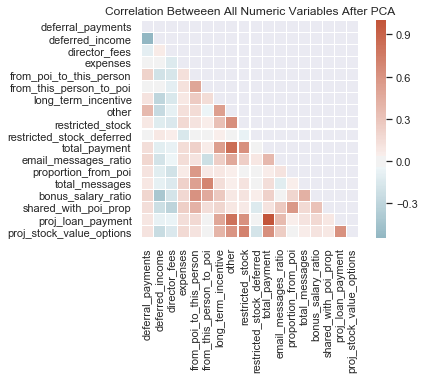

In [145]:

corr_reduced=new_data.drop(['poi'],
                           axis=1).corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_reduced, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio

axes_heat=sns.heatmap(corr_reduced, mask=mask, cmap=cmap, center=0,cbar=True,
            square=True, linewidths=.15, xticklabels=True,yticklabels=True,cbar_kws={"shrink": 1})
#sns.plt.suptitle('lalala')
axes_heat.set_title("Correlation Betweeen All Numeric Variables After PCA")
plt.show()

As expected, we don't see much collinearity any more in the data. This confirms that PCA has helped us to get a set of uncorrelated features. Therefore, no redundant informaton is being conveyed here. Next, we take one more attempt at modeling using logistic regression. To this end, we perform a train/test split. 

In [146]:
X=new_data.drop(['poi'],axis=1).copy()
y=new_data['poi'].copy()

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2, random_state=42,shuffle=True,stratify=y)


In [147]:
#Let's check distribution of poi's in both training as well as testing set.
print y_train.value_counts()
print y_test.value_counts()

0    99
1    14
Name: poi, dtype: int64
0    25
1     4
Name: poi, dtype: int64


In both the sets, the percentage of poi's is quite uniform, hence stratification works. Next, we will use minmax strategy to obtain the values for all features between 0 and 1.

In [148]:
#from sklearn.preprocessing import StandardScaler
scaler = MinMaxScaler()
scaler.fit(X_train[X_train.columns])


MinMaxScaler(copy=True, feature_range=(0, 1))

Now that we have done the fitting of data, next we transform the training set

In [149]:
X_train_scaled = scaler.transform(X_train)
type(X_train_scaled);

In [150]:
#next we use the same parameters to standardize the test set

X_test_scaled=scaler.transform(X_test)
X_test_scaled;

In [151]:
#now we use logistic regression
clf_logit_pca = LogisticRegression().fit(X_train_scaled, y_train)
y_pred_pca=clf_logit_pca.predict(X_test_scaled)

print(classification_report(y_test, y_pred_pca))

             precision    recall  f1-score   support

          0       0.89      0.96      0.92        25
          1       0.50      0.25      0.33         4

avg / total       0.84      0.86      0.84        29



Using newly added features in conjunction with PCA, the precision has improved but we don't observe much difference in Recall score. 

In the inbuilt sickit learn logistic regression model, the default threshld is 0.5. In the next few code lines, we will try to customize it. One possible way to customize is by finding the optimal threshold using ROC curve. Then, we use the optimal threhold to generate new classification report.


In [152]:
pred_proba=clf_logit_pca.predict_proba(X_test_scaled)
pred_proba;

In [153]:
precision,recall,thresholds=precision_recall_curve(y_test,pred_proba[:,1],1)

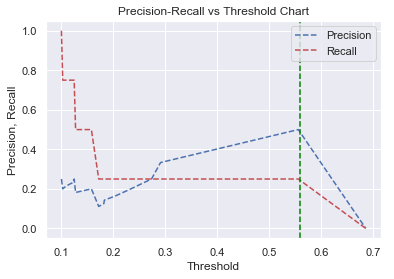

In [154]:
plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[:-1], "b--", label="Precision")
plt.plot(thresholds, recall[:-1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="upper right")
plt.axvline(0.56,color='green',linestyle='--')
#plt.axhline(0.5,color='green',linestyle='-')
#plt.axhline(0.25,color='blue',linestyle='-')
#plt.ylim([0,1])
plt.show()

In [155]:
#y_test
y_test.index = range(0,len(y_test))

In [156]:
display(pd.concat([pd.Series(pred_proba[:,1]),y_test],axis=1))

,0,poi
0,0.069581,0
1,0.071863,0
2,0.092856,0
3,0.097281,0
4,0.183809,0
5,0.274427,0
6,0.080112,0
7,0.207106,0
8,0.182900,0
9,0.103951,0


An interesting observation, How come precision is declining sharply with increase of threshold? If we look at threshold of 0.56, we see in our proba that we have two values 0.56 and 0.68, they are getting predicted as 1 by our model. Please refer to above table. Hence precision is 0.5(no. of true positives divided by total  number of predicted positive). 
And as threshold crosses 0.68 then none of examples are labeled as poi by our model(check output of proba), hence precision goes to 0. 

#### ROC Curve
Another idea is to plot the ROC curve. Each point on the ROC curve represents the values of true positive rate and false positive rate corresponding to a given threshold. Higher the area under the curve(i.e. AUC), better model. We observe that the AUC here is 0.7, which is slightly higher than the AUC obtained using Regularized Logistic Regression.

In [157]:
fpr, tpr, thresholds = metrics.roc_curve(y_test,pred_proba[:,1],1)
roc_auc=metrics.roc_auc_score(y_test,pred_proba[:,1])
#area=0.7

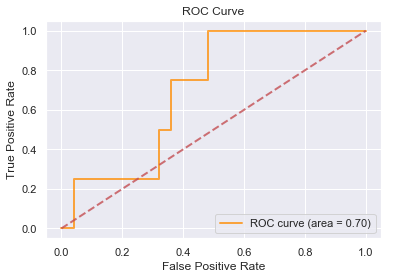

In [158]:
plt.plot(fpr, tpr, lw=2, alpha=0.75, color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [159]:
#find the optimal threshold as before giving equal weightage to both classes
cutoff = thresholds[np.argmax(tpr - fpr)]
cutoff

0.10140069656386884

Now that we know the optimal threshold, we will compute the precision and recall for this threshold. Sickit-learn, by default uses threhsold of 0.5, which might not suffice for all purposes. The threshold, we computed above is low, therefore might lead to high recall but low precision. To compute the precision and recall, we will use the predicted probabilities, pred_proba. Since we are mostly concerned about identifying POI's, we will select the second column of this array, pred_proba.

In [160]:
probs=pred_proba[:,1]
probs[probs>=cutoff]=1
probs[probs<cutoff]=0
probs

array([0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1.,
       1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0.])

In [161]:
pred_proba[:,1]

array([0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1.,
       1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0.])

In [162]:
recall=recall_score(y_test,probs)
precision= precision_score(y_test, probs)
print 'Recall is %0.2f' %recall 
print 'Precision is %0.2f' %precision


Recall is 1.00
Precision is 0.25


So, we obtained perfect recall score at the cost of low precision. A trade-off between precision and recall with changing the thresholds is expected. In the case of identifying POI's it makes sense to have high recall so as not to miss the POI's. It is more important to capture all the POI's, in other words persons responsible for the corruption. Meanwhile, if few non-POI's get flagged as POI (i.e. false positive), it is okay.



## Random Forests

Earlier, we saw that we achieved perfect recall score at the cost of low precision. The precision-recall tradeoff is a typical problem in classification algorithms. In an attempt to increase the recall without sacrificing too much on precision, it is needed to make a better model. Random forests have been a popular classification algorithm which is least likely to overfit because of averaging as well as low bias. On top of that, it has an in-built feature selection algorithm. To begin with, we will construct a simple random forest classifier. No feature engineering will be introduced. Only original set of features will be used.


In [163]:
rf_data=df_new.drop(['poi','employees','email_address'],axis=1)
y=df_new['poi'].copy()


In [164]:
#split the data and preprocessing

rf_train,rf_test,y_train,y_test = train_test_split(rf_data,y,test_size=0.2,shuffle=True,stratify=y,random_state=0)
scaler = MinMaxScaler()
scaler.fit(rf_train)
rf_train_scaled = scaler.transform(rf_train)
rf_test_scaled = scaler.transform(rf_test)

### Hyperparameter Tuning
One of the main features of Random Forests is selecting the optimal value of the hyperparameters. It has several hyperparameters that need to be tuned, such as number of Decision trees, Depth of the tree, Number of features used for splitting at each node in the tree, Minimum number of samples at a leaf so as to allow splitting etc. As we saw in the section on Regularization, cross validation is a suitable approach to select optimal values for these parameters. 
One possible approach is to define a list of values for each of the above hyperparameters and then use cross validation. But with so many hyperparameters, implementing cross-validation with each combination of values might be cumbersome. So we can start with tuning relatively more important hyperparameters, number of Decision trees, number of features selected for splitting at a tree node, and maximum depth of the tree.  

We can use either grid search or randomized search and implement cross validation for each combination of values. The main difference between these two search strategies is, grid search executes cross validation for each combination of values, whereas ranodmized search randomly selects combinations of values and performs validation for only those combinations.   

An important question to consider, is it okay to use AUC rather than a F1 score as a metric for validation?  yes we can use AUC as a validation metric and actually it is a better option since AUC is threshold independent, whereas F1 score takes a default threshold of 0.5 unless we provide a range of threshold values. So the next approach shd be; for every hyperparameter combination find the AUC cross each validation set. Once we get the highest AUC for a given hyperparameter combination, we will use that to train our entire training set. And then find predicted probabilities on the test set. Get a distribution of predicted probabilities (i.e. histogram) and choose the optimal threshold accordingly.

#### Using AUC for Hyperparameter Selection
We have already defined the base classifier as well as a parameter grid. Next, we perform grid search cross validation, but this time we use AUC score as the performance metric. We use the similar approach as we did while finding optimal value for regularization parameter, $C$.

For each parameter combination;
 * Perform 5-fold validation on train set,
 * Predict probabilities on each fold,
 * Concatenate the predicted probbailities to get enough sample size,
 * Use the concatenated list of predicted probabilities together with the entire training set to obtain the AUC.

In [165]:
n_estimators= [5,10,20,50]
max_features= ["auto","sqrt"]
max_depth=[4,6,8]
para_grid=product(n_estimators,max_features,max_depth)


In [166]:
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

def optimal_auc(para_grid,skf,rf_train_scaled,y_train):
    best_score=0
    dict_new={}
    df_results=pd.DataFrame(columns=["Pred_proba","y_true"])
    for param in para_grid:
        proba_list=[]
        test_list=[]
        for train_index, test_index in skf.split(rf_train_scaled, y_train):
            X_train, X_valid = rf_train_scaled[train_index], rf_train_scaled[test_index]
            y_train_new, y_valid = np.array(y_train)[train_index], np.array(y_train)[test_index]
        
            clf_rf = RandomForestClassifier(max_depth= param[2], max_features= param[1], n_estimators= param[0],\
                                            random_state=42).fit(X_train, y_train_new)
            probab=clf_rf.predict_proba(X_valid)
            proba_list=proba_list+list(probab[:,1])
            test_list=test_list+list(y_valid)
    
        roc_auc=metrics.roc_auc_score(np.array(test_list),np.array(proba_list))
        if roc_auc>best_score:
            best_score=roc_auc
            print best_score
            df_results['Pred_proba']=np.array(proba_list)
            df_results['y_true']=np.array(test_list)
            #dict_new[param]=(np.array(test_list),np.array(proba_list),roc_auc)
        
    #df_results=df_results.append({"Max Depth":param[2],"No. of Estimators":param[0],"Max Features":param[1],"AUC":roc_auc},ignore_index=True)
    #print "For the parameter combination %0.2f the AUC is %0.2f" %param  %roc_auc
    return (df_results,param)


In [167]:
roc_data=optimal_auc(para_grid,skf,rf_train_scaled,y_train)

0.7225829725829727
0.801948051948052
0.8084415584415583
0.8167388167388168
0.8369408369408369
0.8398268398268398


Using the predicted probabilities and true values for y, obtained corresponding to the optimal set of hhyperparameters, we plot the ROC curve.

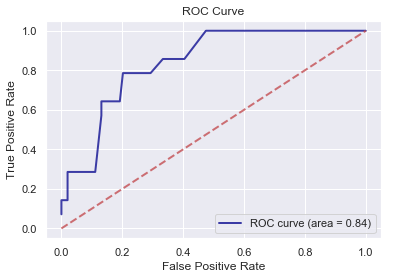

In [168]:
fpr, tpr, thresholds = metrics.roc_curve(np.array(roc_data[0]['y_true']),np.array(roc_data[0]['Pred_proba']),1)
roc_auc=metrics.roc_auc_score(np.array(roc_data[0]['y_true']),np.array(roc_data[0]['Pred_proba']))
plt.plot(fpr, tpr, lw=2, alpha=0.75, color='darkblue',label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
plt.legend(loc="lower right")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve")
plt.show()

Choosing the threshold is the next task. It is better to do this choice based on the validation set, as we did for the optimal set of hyperparameters.

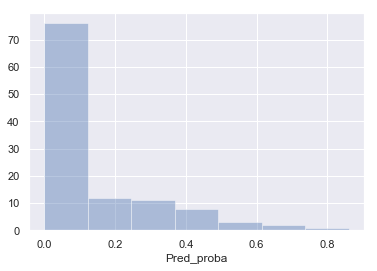

In [169]:
ax_probs=sns.distplot(roc_data[0]['Pred_proba'],bins=7,kde=False)
plt.show()

In order to choose the optimal threshold, the most important question to consider is; do we want to identify all POI's with certainity? As discussed earlier, changing threshold is a trade-off between senstivity(TPR) and specificity(1-FPR). 

In [170]:
print thresholds[0:10]

[0.86 0.7  0.6  0.5  0.44 0.42 0.36 0.32 0.28 0.26]


In [171]:
# define a function that accepts a threshold and prints sensitivity and specificity(1-fpr)
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

The above function works because, thresholds(or predicted probabilities) is arranged in decreasing order where as tpr as well as FPR are ordered in ascending order. Using the istogram lotted above and this function, we will try few values for threshold.

In [172]:
evaluate_threshold(0.4)

('Sensitivity:', 0.2857142857142857)
('Specificity:', 0.9090909090909091)


In [176]:
evaluate_threshold(0.25)

('Sensitivity:', 0.6428571428571429)
('Specificity:', 0.8383838383838383)


Here we will go for lower threshold, so as to catch almost all the POI's. Next step is to train the classifier with optimal hyperparameters on the entire training set and predict probailities on test set.

In [177]:
rf_optimal_auc=RandomForestClassifier(max_depth= 8, max_features= 'sqrt', n_estimators= 20)
rf_optimal_auc.fit(rf_train_scaled,y_train)
#fpr, tpr, thresholds = metrics.roc_curve(np.array(y_train),np.array(rf_predict_train_probs[:,1]),1)
test_probs=rf_optimal_auc.predict_proba(rf_test_scaled)
test_probs[:,1][test_probs[:,1]>=0.25]=1
test_probs[:,1][test_probs[:,1]<0.25]=0

In [178]:
print classification_report(y_test,test_probs[:,1])

             precision    recall  f1-score   support

          0       0.84      0.64      0.73        25
          1       0.10      0.25      0.14         4

avg / total       0.74      0.59      0.65        29



### Discussion and Conclusion
In this post, we studied two different approaches to classification, Logistic regression with Regularization, and Random Forests. We learned about different approaches to Hyperparameter tuning. Cross-validation is essential to Hyperparameter tuning so as to prevent overfitting.

The main takeaway from this post is the novel approach to perform cross validation, discussed in the section, AUC for Hyperparameter Selection. Since, we have a very small dataset, we tried to use a novel approach to perform cross validation. Rather than using standard Grid Search approach or Randomized Search approach, we came up with a new approach so that scarcity of data is not an obstacle. 